In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path
sys.path.append('../scenes/')
import syndiff as sd 

from astropy.visualization import (SqrtStretch, ImageNormalize)
from copy import deepcopy
from scipy.ndimage import rotate
import matplotlib.patches as patches
from matplotlib.path import Path

from scipy.optimize import minimize

In [2]:
ra = 299.6193292     
dec = 62.1377889
# host fqv
#ra = 189.1428830     
#dec = 11.2386300
size = 15
filts = ['g','r','i','z','y']
ps1 = sd.PS1_images(ra,dec,size,filts)

../scenes/ps1_funcs.py:183: RuntimeWarning: invalid value encountered in log10
  m = -2.5*np.log10(ima) + 25 + 2.5*np.log10(im.header['EXPTIME'])
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


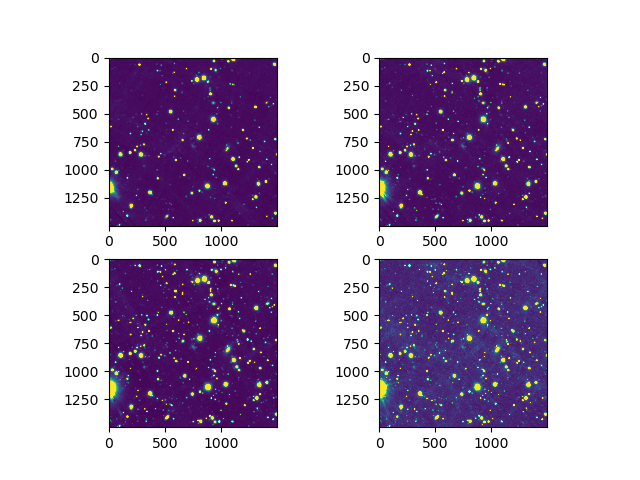

In [3]:
plt.figure()
plt.subplot(221)
plt.imshow(ps1['g'],vmin=0,vmax=1)
plt.subplot(222)
plt.imshow(ps1['r'],vmin=0,vmax=1)
plt.subplot(223)
plt.imshow(ps1['i'],vmin=0,vmax=1)
plt.subplot(224)
plt.imshow(ps1['z'],vmin=0,vmax=1)

/Users/rridden/miniconda3/lib/python3.7/site-packages/lightkurve/search.py:233: LightkurveWarning: Warning: 7 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


<IPython.core.display.Javascript object>


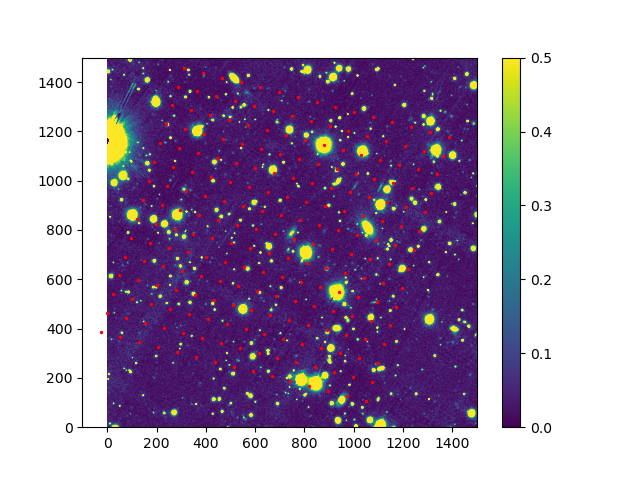

In [3]:
tpf14 = sd.Get_TESS(ra,dec,14,)

tess_corners = sd.Get_TESS_corners(tpf14, ps1['wcs'])
plt.figure()
#plt.subplot(projection=wcs)
plt.imshow(ps1['i'],origin='lower',vmax=.5)
plt.colorbar()
plt.scatter(tess_corners[0,:,:].flatten(),tess_corners[1,:,:].flatten(),c='r',s=2)

<IPython.core.display.Javascript object>


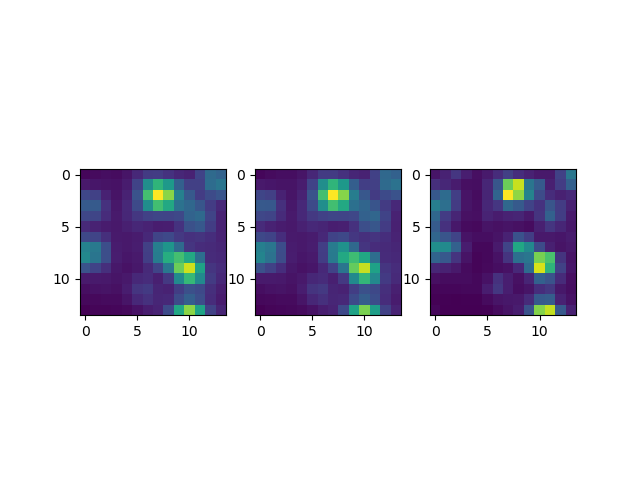

In [4]:
ps1conv = sd.Convolve_PS1(ps1,tpf14,tess_corners)
down = sd.Regrid_PS1(ps1conv,tess_corners)
comp = sd.PS1_tess_comp(down)
frac = sd.PS1_tess_frac(down)
plt.figure()
plt.subplot(131)
plt.imshow(comp)
plt.subplot(132)
plt.imshow(frac)
plt.subplot(133)
plt.imshow(tpf14.flux[100])

In [6]:
tpf14.row

757

In [7]:
tpf14.column

447

<IPython.core.display.Javascript object>


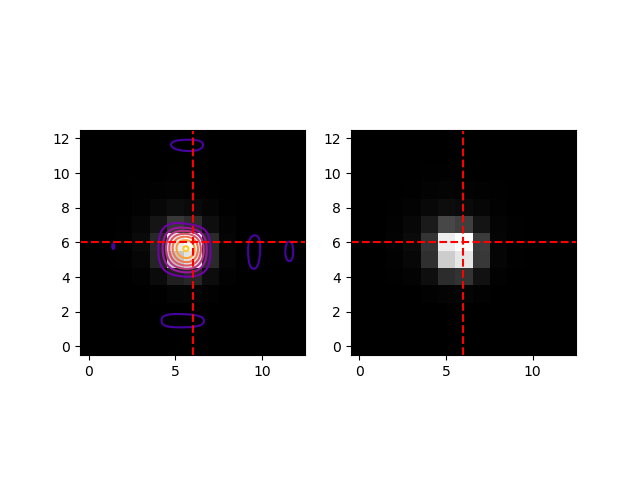

In [6]:
iprf = sd.Interp_PRF(tpf14.row,tpf14.column,tpf14.camera,tpf14.ccd,100,Method='RBS')
#iprf = np.fliplr(np.flipud(iprf))
prf = sd.Get_PRF(tpf14.row,tpf14.column,tpf14.camera,tpf14.ccd)
d = sd.Downsample(iprf,100,pix_response=False)
plt.figure()
plt.subplot(121)
plt.imshow(prf/np.nanmax(prf),origin='lower',cmap='gray')
plt.contour(iprf,extent=(-0.5,12.5,-0.5,12.5),cmap='plasma')
plt.axvline(6,ls='--',color='r')
plt.axhline(6,ls='--',color='r')
plt.subplot(122)
plt.imshow(d/np.nanmax(d),origin='lower',cmap='gray')
plt.axvline(6,ls='--',color='r')
plt.axhline(6,ls='--',color='r')

In [13]:
def Convolve_PS1(ps1,tpf,corners=None):
    """
    Convolve the PS1 image with the DAVE TESS PRF models.
    If corners are given the PRF will be oriented with the ps1 image
    """
    
    #PRF = sd.Get_PRF(tpf.row + (12/2), tpf.column + (12/2),
    #          tpf.camera,tpf.ccd)
    PRF = sd.Interp_PRF(tpf.row + (12/2), tpf.column + (12/2),
                          tpf.camera,tpf.ccd,100)
    if corners is not None:
        x = corners[0,0,1] - corners[0,0,0]
        y = corners[1,0,1] - corners[1,0,0]
        ang = np.arctan(x/y)*180/np.pi
        print(corners)
        PRF = sd.rotate(np.fliplr(PRF),ang)
        
    conv = sd.deepcopy(ps1)
    for key in list(ps1.keys())[:-1]:
        conv[key] = sd.signal.fftconvolve(ps1[key], PRF, mode='same')
    return conv